# 回帰分析
外れ値の存在に大きく左右されるため、それを取り除くことは重要。検出する統計学的検定法はいろいろある。

### データセット

In [1]:
# Ames Housing Dataset
import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
              'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('https://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t', usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### 探索的データ解析(exploratory data analysis:EDA)

MLxtendライブラリのscatterplotmatrix関数を用いる。各変数における分布を散布図行列として表示する。

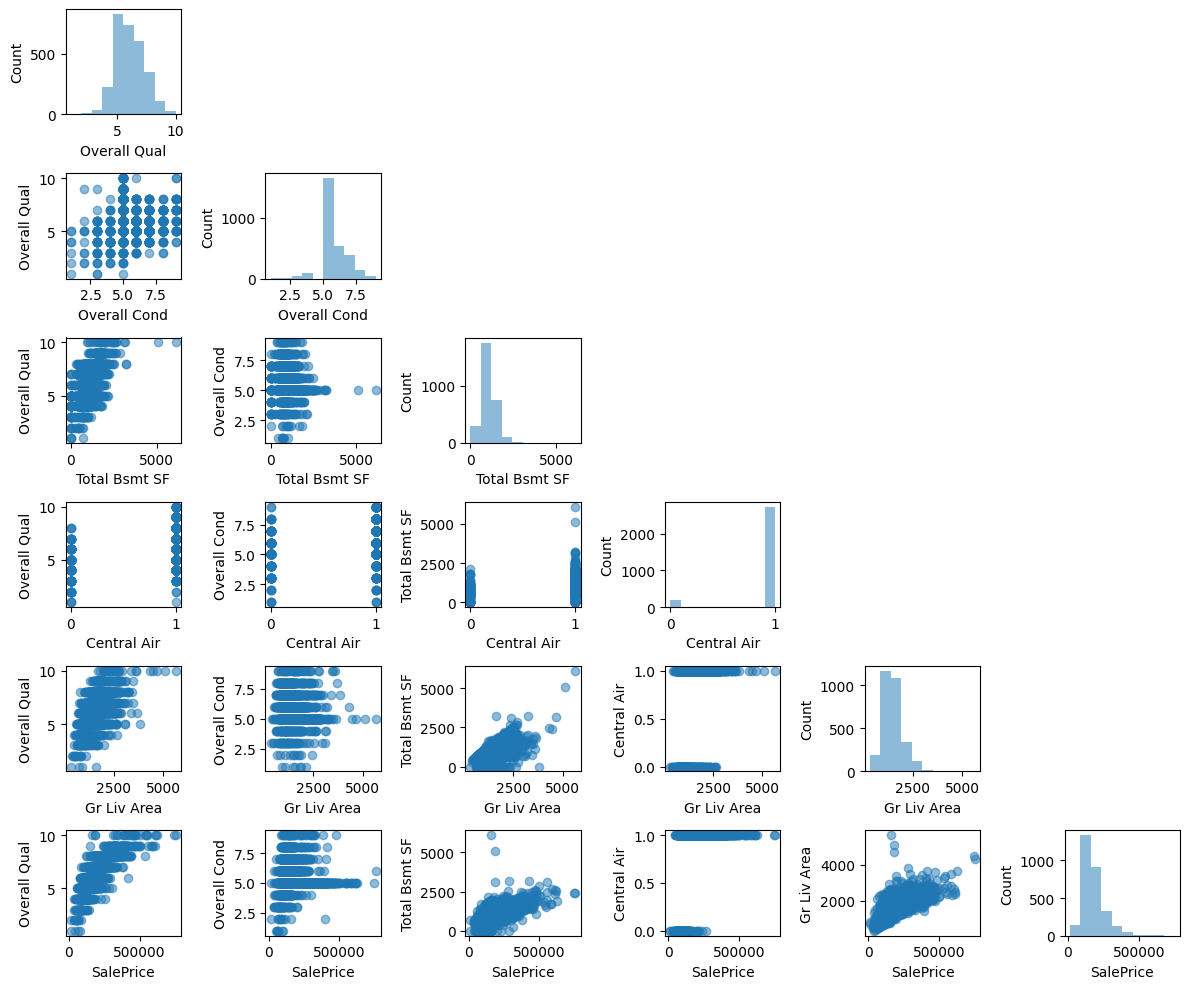

In [6]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

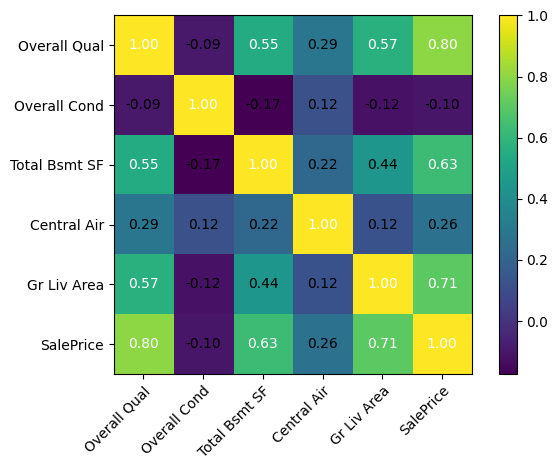

In [7]:
# 相関行列
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

'SalePrice'との相関が最も高い連続値の変数は'Gr Liv Area'であることがわかる。

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        # 重みとバイアスの初期化
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.hstack([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.sum() / X.shape[0]
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [9]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() # １次元を２次元に変換し、標準化した後、再び１次元に戻す
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

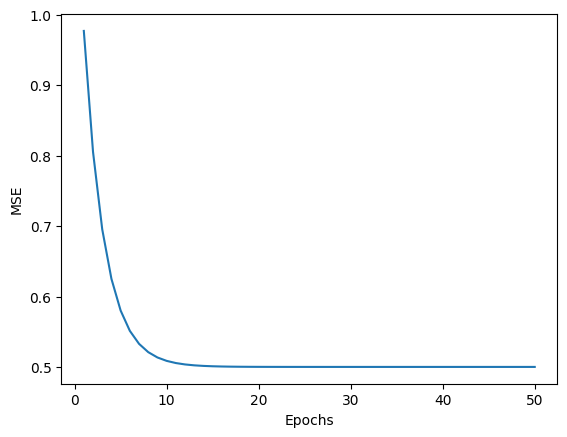

In [10]:
plt.plot(range(1, lr.n_iter + 1), lr.losses_)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [11]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2) 
    return 

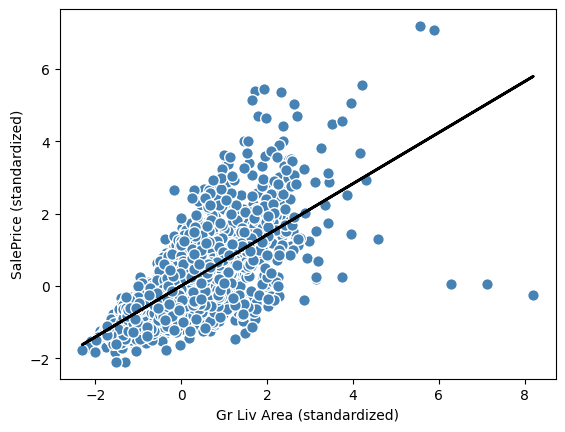

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Gr Liv Area (standardized)')
plt.ylabel('SalePrice (standardized)')
plt.show()

In [13]:
# 2000平方フィートの住宅の予測価格を計算
# 逆変換を行う
feature_std = sc_x.transform(np.array([[2000]]))
target_std = lr.predict(feature_std)
target_reversed = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sales price: ${target_reversed.flatten()[0]:.2f}')

Sales price: $236674.72


In [14]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


ロジスティック回帰はクラス分類を目的とし、線形回帰は連続値の予測を目的とする。

### ライブラリ

In [15]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 111.666
Intercept: 13342.979


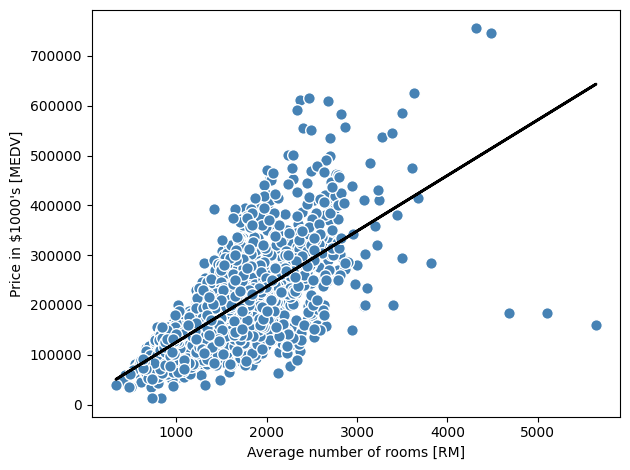

In [16]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

### 線形回帰の解析的な求解  
閉形式も求めることができるが、非常に大きなデータセットを扱っている場合は、逆行列を$w=(X^T X)^{-1} X^T y$で求める際に計算量的に高くつく。また、訓練データからなる行列が逆行列を、持たない特異行列であり、可逆ではないかもしれない。反復法はこのようなケースにも対応できる。

## RANSAC
外れ値の除去に代わるアルゴリズム  
1. データからランダムに n 個の点を選ぶ（候補サンプル）
2. その点からモデル（例：直線）を推定する
3. 残りの全データに対して、そのモデルの誤差を計算する
4. モデルに **十分に近い点（距離 < t）** を「インライア」とみなす
5. インライアの数が d 以上なら、その点で再度モデルを推定する
6. モデルを保存（インライア数や誤差が最大のものを常に更新）

In [17]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                            max_trials=100, 
                            min_samples=0.95, 
                            residual_threshold=None, # NoneにするとMADを使って正常値と外れ値を自動的に判定
                            random_state=123)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

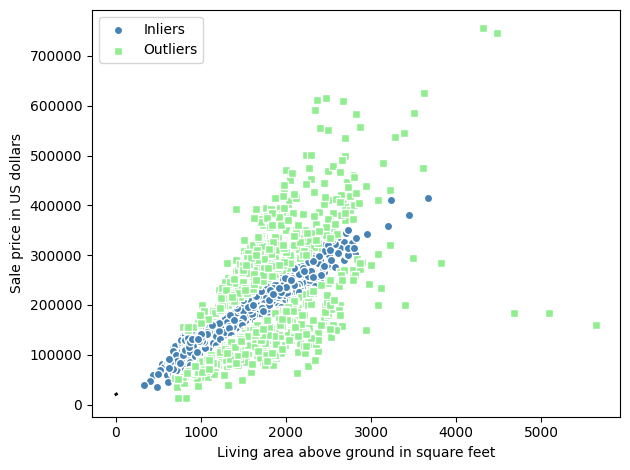

In [18]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolors='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', edgecolors='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in US dollars')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [19]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 106.348
Intercept: 20190.093


## 性能評価

In [20]:
from sklearn.model_selection import train_test_split
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

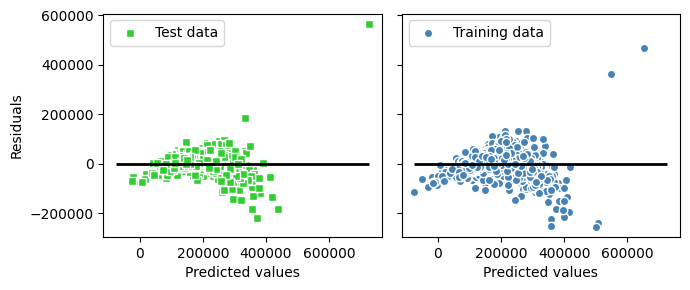

In [21]:
# 残差プロット
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', edgecolors='white', marker='s', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, 
            c='steelblue', edgecolors='white', marker='o', label='Training data')
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)
plt.tight_layout()
# plt.savefig('./figures/residuals.png', dpi=300)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))

# 決定係数。モデルによって捕捉された応答変数の分散の割合。1に近い方が良い。
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1497216245.853, test: 1516565820.999
MAE train: 25983.027, test: 24921.289
R^2 train: 0.769, test: 0.752


## 正規化手法
Elastic Net：リッジ回帰(L2)とLASSO(L1)の折衷案

In [23]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge = Ridge(alpha=1.0, random_state=123)
lasso = Lasso(alpha=1.0, random_state=123)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=123)

## 多項式回帰
$y=w_1x+w_2x^2+...+w_dx^d+b$  
重回帰モデルと見なされる。

In [24]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [25]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
# ２次の多項式特徴量のクラスをインスタンス化
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X) # 2次までの特徴量を作成。例:[1, x, x^2]

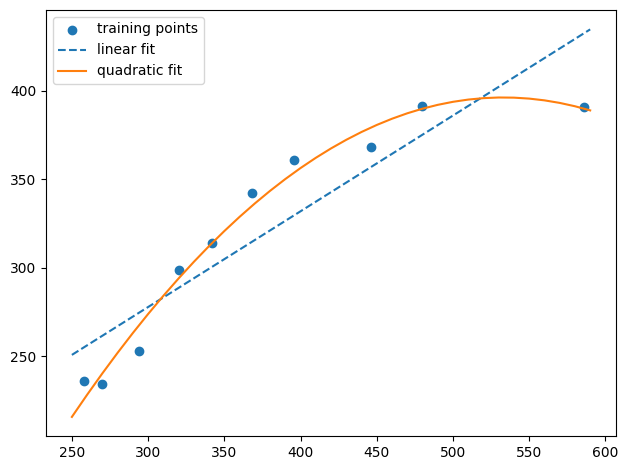

In [26]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [27]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


In [28]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]

# # 特徴量変更
# X = df[['Overall Qual']].values
# y = df['SalePrice'].values

In [29]:
regr = LinearRegression()
# 2次と3次の特徴量を作成
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
#　適合させる
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

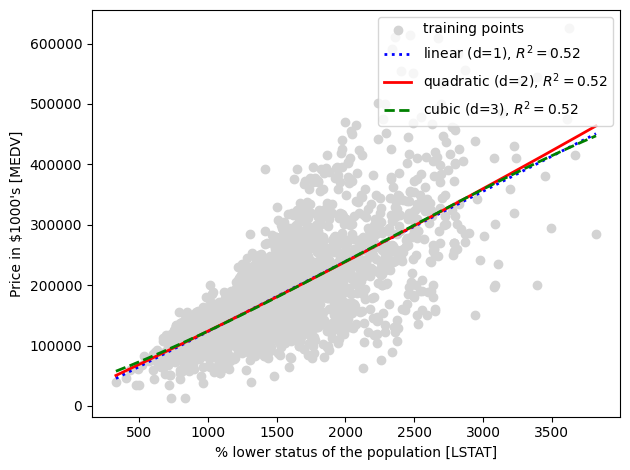

In [30]:
# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

## ランダムフォレスト回帰
連続値の変数に適した不純度指標が必要なため、平均二乗誤差を定義する。つまりノードにおける目的変数の予測と正解値の分散。

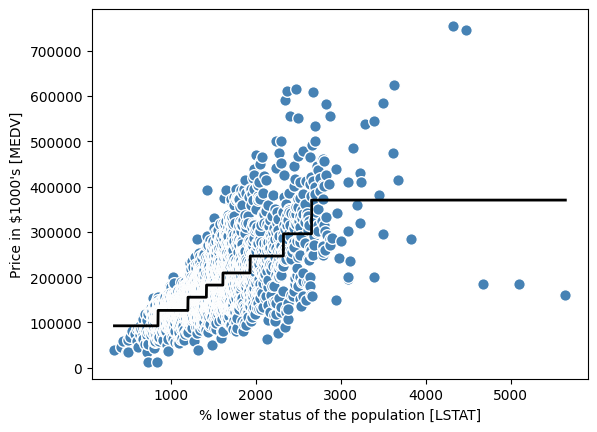

In [31]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

In [32]:
from sklearn.model_selection import train_test_split
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [33]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 155009129.891, test: 933880448.846
R^2 train: 0.976, test: 0.847


ランダムフォレストは訓練データを過学習する傾向にあることがわかる。

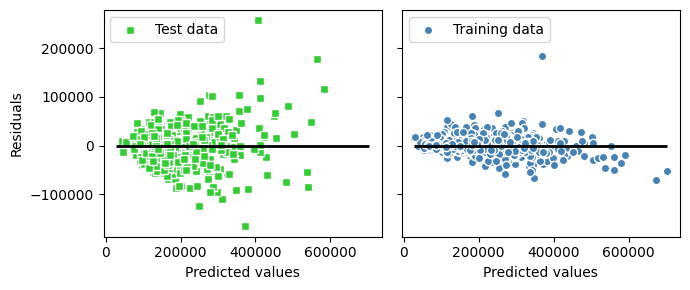

In [34]:
# 残差プロット
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', edgecolors='white', marker='s', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, 
            c='steelblue', edgecolors='white', marker='o', label='Training data')
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)
plt.tight_layout()
# plt.savefig('./figures/residuals.png', dpi=300)
plt.show()

線形モデルの残差プロットと比較すれば、大きく改善している。  
残差プロットの非ランダム性に対処するための普遍的なアプローチは存在せず、実験を行う必要がある。